# Sikkema

## Sikkema

### Setting up environment

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../"))
sys.path.insert(0, os.path.abspath("../nsforest/nsforesting"))
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import nsforest as ns
from nsforest import utils
from nsforest import preprocessing as pp
from nsforest import nsforesting
from nsforest import evaluating as ev
from nsforest import plotting as pl

/Users/adeslatt/miniconda3/envs/nsforest/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/adeslatt/miniconda3/envs/nsforest/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/adeslatt/miniconda3/envs/nsforest/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/adeslatt/miniconda3/envs/nsforest/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/Users/adeslatt/miniconda3/envs/nsforest/lib/python3.11/site-packages/anndata/util

### Data Exploration

#### Loading h5ad AnnData file

In [2]:
data_folder = "../../sikkema/"
file = data_folder + "b351804c-293e-4aeb-9c4c-043db67f4540.h5ad"
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 584944 × 27957
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

#### Defining `cluster_header` as cell type annotation. 

**Note:** Some datasets have multiple annotations per sample (ex. "broad_cell_type" and "granular_cell_type"). NS-Forest can be run on multiple `cluster_header`'s. Combining the parent and child markers may improve classification results. 

In [3]:
cluster_header = "cell_type_ontology_term_id"

#### Defining `output_folder` for saving results.  And create the folder if it does not exist.

In [12]:
output_folder = "../../sikkema_output/"
os.makedirs(output_folder, exist_ok=True)  # Create directory if it doesn't exist

#### Looking at sample labels

In [13]:
adata.obs_names

Index(['GCGACCATCCCTAACC_SC22', 'P2_1_GCGCAACCAGTTAACC',
       'GCTCTGTAGTGCTGCC_SC27', 'P2_8_TTAGGACGTTCAGGCC',
       'CTTGATTGTCAGTTTG_T164', 'P3_3_CCACTACTCATTGCGA',
       'P2_1_CAGCAGCGTGTTGAGG', 'P1_4_TTGCGTCAGCTTCGCG',
       'GTCACGGAGACGCAAC_F02617', 'CAGCCACAGTCACTA_GRO-03_biopsy',
       ...
       'CGGACACAGCCATCGC-1-HCATisStab7659970', 'P2_3_GCGCCAATCGGTCTAA',
       'CAGAATCCATGGTAGG-1-4', 'TTCTACACATACTACG_T85',
       'ATGAGGGTCCCTCTCC_SC143', 'ACCTTTACATTAACCG_T120',
       'CATTATCTCCATGAAC_F01639', 'AGGCCGTGTGTGACCC-SC56',
       'CGATGGCAGCAGGCTA-1-2', 'AATCGGTGTCGGCACT-1-4'],
      dtype='object', length=584944)

#### Looking at genes

**Note:** `adata.var_names` must be unique. If there is a problem, usually it can be solved by assigning `adata.var.index = adata.var["ensembl_id"]`. 

In [14]:
adata.var_names

Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001561', 'ENSG00000001626', 'ENSG00000002330',
       'ENSG00000002549',
       ...
       'ENSG00000277443', 'ENSG00000277632', 'ENSG00000277639',
       'ENSG00000277734', 'ENSG00000277791', 'ENSG00000277972',
       'ENSG00000278311', 'ENSG00000279483', 'ENSG00000281649',
       'ENSG00000283103'],
      dtype='object', length=4898)

#### Checking cell annotation sizes 

**Note:** Some datasets are too large and need to be downsampled to be run through the pipeline. When downsampling, be sure to have all the granular cluster annotations represented. 

In [15]:
adata.obs[cluster_header].value_counts()

cell_type_ontology_term_id
CL:0002633    80113
CL:0000583    78816
CL:0002063    62405
CL:0000158    36023
CL:0002480    35833
CL:0002145    35225
CL:0000625    29074
CL:0000861    28223
CL:0002144    23205
CL:0000624    21285
CL:0000860    17695
CL:0000623    16978
CL:0002543    12975
CL:4028006    10321
CL:0002399     9133
CL:0000875     8834
CL:0002062     7937
CL:1001568     7391
CL:0000097     6623
CL:0005012     5873
CL:4028004     5182
CL:1001603     4805
CL:4030023     4600
CL:0002138     4595
CL:0000236     4511
CL:0002632     4393
CL:0009089     3032
CL:0019019     2996
CL:0000786     1773
CL:1000312     1670
CL:2000093     1573
CL:0000313     1472
CL:0010003     1440
CL:0019001     1417
CL:0000622     1274
CL:0019003      968
CL:0000186      716
CL:0005006      561
CL:0000192      556
CL:0000784      552
CL:0000319      537
CL:0000084      500
CL:0000499      335
CL:0000990      322
CL:0000451      312
CL:0000057      276
CL:0000077      230
CL:0002075      165
CL:1000223   

### Preprocessing

#### Generating scanpy dendrogram

**Note:** Only run if there is no pre-defined dendrogram order. This step can still be run with no effects, but the runtime may increase. 

Dendrogram order is stored in `adata.uns["dendrogram_cluster"]["categories_ordered"]`. 

This dataset has a pre-defined dendrogram order, so running this step is not necessary. 

In [16]:
ns.pp.dendrogram(adata, cluster_header, save = True, output_folder = output_folder, outputfilename_suffix = cluster_header)

/Users/adeslatt/miniconda3/envs/nsforest/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


#### Calculating cluster medians per gene

Run `ns.pp.prep_medians` before running NS-Forest.

**Note:** Do **not** run if evaluating marker lists. Do **not** run when generating scanpy plots (e.g. dot plot, violin plot, matrix plot). 

In [17]:
adata = ns.pp.prep_medians(adata, cluster_header)
adata

Calculating medians...


Calculating medians (means) per cluster: 100%|████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


Saving calculated medians as adata.varm.medians_cell_type_ontology_term_id
--- 39.43401098251343 seconds ---
median: 0.0
mean: 0.18186754
std: 0.5669553
Only positive genes selected. 4898 positive genes out of 4898 total genes


AnnData object with n_obs × n_vars = 584944 × 4898
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

#### Calculating binary scores per gene per cluster

Run `ns.pp.prep_binary_scores` before running NS-Forest. Do not need to run if evaluating marker lists. Do not need to run when generating scanpy plots. 

In [18]:
adata = ns.pp.prep_binary_scores(adata, cluster_header)
adata

Calculating binary scores...


Calculating binary scores per cluster: 100%|██████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.80it/s]

Saving calculated binary scores as adata.varm.binary_scores_cell_type_ontology_term_id
--- 13.184026718139648 seconds ---
median: 0.0
mean: 0.09153821921453578
std: 0.2463153341216742


AnnData object with n_obs × n_vars = 584944 × 4898
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

#### Plotting median and binary score distributions

Saving median distributions as...
../../sikkema_output/cell_type_ontology_term_id_medians.png


<Figure size 640x480 with 0 Axes>

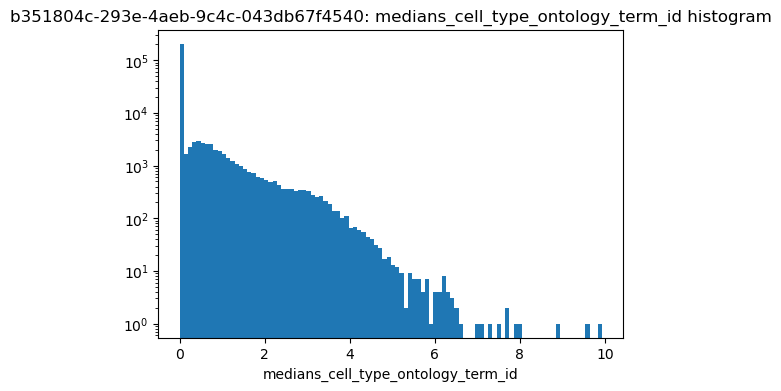

In [19]:
plt.clf()
filename = output_folder + cluster_header + '_medians.png'
print(f"Saving median distributions as...\n{filename}")
a = plt.figure(figsize = (6, 4))
a = plt.hist(adata.varm["medians_" + cluster_header].unstack(), bins = 100)
a = plt.title(f'{file.split("/")[-1].replace(".h5ad", "")}: {"medians_" + cluster_header} histogram')
a = plt.xlabel("medians_" + cluster_header)
a = plt.yscale("log")
a = plt.savefig(filename, bbox_inches='tight')
plt.show()

Saving binary_score distributions as...
../../sikkema_output/cell_type_ontology_term_id_binary_scores.png


<Figure size 640x480 with 0 Axes>

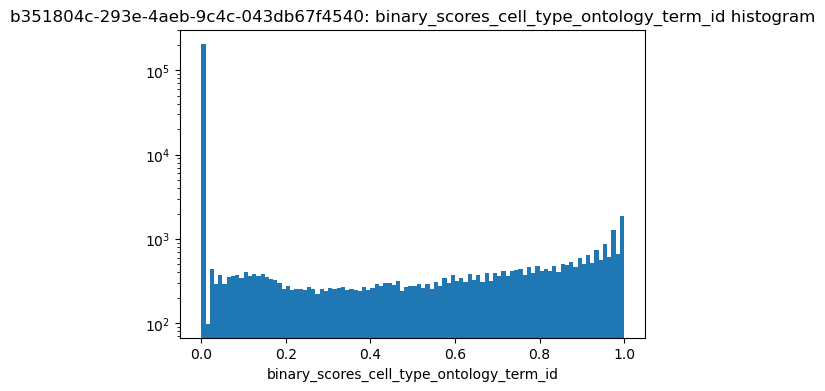

In [20]:
plt.clf()
filename = output_folder + cluster_header + '_binary_scores.png'
print(f"Saving binary_score distributions as...\n{filename}")
a = plt.figure(figsize = (6, 4))
a = plt.hist(adata.varm["binary_scores_" + cluster_header].unstack(), bins = 100)
a = plt.title(f'{file.split("/")[-1].replace(".h5ad", "")}: {"binary_scores_" + cluster_header} histogram')
a = plt.xlabel("binary_scores_" + cluster_header)
a = plt.yscale("log")
a = plt.savefig(filename, bbox_inches='tight')
plt.show()

#### Saving preprocessed AnnData as new h5ad

In [21]:
filename = file.replace(".h5ad", "_preprocessed.h5ad")
print(f"Saving new anndata object as...\n{filename}")
adata.write_h5ad(filename)

Saving new anndata object as...
../../sikkema/b351804c-293e-4aeb-9c4c-043db67f4540_preprocessed.h5ad


### Running NS-Forest

**Note:** Do not run NS-Forest if only evaluating input marker lists. 

In [ ]:
outputfilename_prefix = cluster_header
results = nsforesting.NSForest(adata, cluster_header, save_supplementary = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Preparing adata...
--- 3.084024667739868 seconds ---
Pre-selecting genes based on binary scores...
	BinaryFirst_high Threshold (mean + 2 * std): 0.5841688874578842
	Average number of genes after gene_selection in each cluster: 421.74
Saving number of genes selected per cluster as...
../../sikkema_output/cell_type_ontology_term_id_gene_selection.csv
Number of clusters to evaluate: 50
1 out of 50:
	CL:0000037
	Pre-selected 665 genes to feed into Random Forest.


In [ ]:
results

#### Plotting classification metrics from NS-Forest results

In [ ]:
ns.pl.boxplot(results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

### Plotting scanpy dot plot, violin plot, matrix plot for NS-Forest markers

**Note:** Assign pre-defined dendrogram order here **or** use `adata.uns["dendrogram_" + cluster_header]["categories_ordered"]`. 

In [ ]:
to_plot = results.copy()

In [ ]:
dendrogram = [] # custom dendrogram order
dendrogram = list(adata.uns["dendrogram_" + cluster_header]["categories_ordered"])
to_plot["clusterName"] = to_plot["clusterName"].astype("category")
to_plot["clusterName"] = to_plot["clusterName"].cat.set_categories(dendrogram)
to_plot = to_plot.sort_values("clusterName")
to_plot = to_plot.rename(columns = {"NSForest_markers": "markers"})
to_plot.head()

In [ ]:
markers_dict = dict(zip(to_plot["clusterName"], to_plot["markers"]))
markers_dict

In [ ]:
ns.pl.dotplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.stackedviolin(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.matrixplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

### Evaluating input marker list

#### Getting marker list in dictionary format: {cluster: marker_list}

In [ ]:
data_folder = "../../demo_data/"
file = data_folder + "marker_list.csv"

markers = pd.read_csv(file)
markers_dict = utils.prepare_markers(markers, "clusterName", "markers")
markers_dict

In [ ]:
outputfilename_prefix = "marker_eval"
evaluation_results = ev.DecisionTree(adata, cluster_header, markers_dict, combinations = False, use_mean = False, 
                                     save_supplementary = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
evaluation_results

#### Plotting classification metrics from marker evaluation

In [ ]:
ns.pl.boxplot(evaluation_results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(evaluation_results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(evaluation_results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.boxplot(evaluation_results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

In [ ]:
ns.pl.scatter_w_clusterSize(evaluation_results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

### Plotting scanpy dot plot, violin plot, matrix plot for input marker list

**Note:** Assign pre-defined dendrogram order here **or** use `adata.uns["dendrogram_" + cluster_header]["categories_ordered"]`. 

In [ ]:
to_plot = evaluation_results.copy()

In [ ]:
dendrogram = [] # custom dendrogram order
dendrogram = list(adata.uns["dendrogram_" + cluster_header]["categories_ordered"])
to_plot["clusterName"] = to_plot["clusterName"].astype("category")
to_plot["clusterName"] = to_plot["clusterName"].cat.set_categories(dendrogram)
to_plot = to_plot.sort_values("clusterName").reset_index(drop = True)
to_plot = to_plot.rename(columns = {"NSForest_markers": "markers"})
to_plot.head()

In [ ]:
markers_dict = dict(zip(to_plot["clusterName"], to_plot["markers"]))
markers_dict

In [ ]:
ns.pl.dotplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.stackedviolin(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

In [ ]:
ns.pl.matrixplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)